In [10]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [11]:
# 1. Setup & Configuration
DATA_DIR = "/kaggle/input/wikiart"
selected_classes = ["Impressionism", "Realism", "Expressionism", "Romanticism", "Post_Impressionism"]
NUM_CLASSES = len(selected_classes)
BATCH_SIZE = 32
EPOCHS = 13  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
# 2. Dataset Preparation (FIXED SPLIT)
# Basic transform to read data initially
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [13]:
# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=base_transform)

# Filter for selected classes
selected_idx = [full_dataset.class_to_idx[c] for c in selected_classes]
filtered_samples = [(path, selected_idx.index(label))
                    for path, label in full_dataset.samples if label in selected_idx]

# Extract labels for stratified split
all_labels = [label for _, label in filtered_samples]

print(f"Total filtered images: {len(filtered_samples)}")


Total filtered images: 43998


In [14]:
# --- FIX: Proper Train / Val / Test Split ---
train_val_samples, test_samples, train_val_labels, test_labels = train_test_split(
    filtered_samples, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_samples, val_samples = train_test_split(
    train_val_samples, test_size=0.2, random_state=42, stratify=train_val_labels
)

print(f"Train size: {len(train_samples)}")
print(f"Val size:   {len(val_samples)}")
print(f"Test size:  {len(test_samples)}")

# Custom Dataset Class
class FilteredWikiArt(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


Train size: 28158
Val size:   7040
Test size:  8800


In [15]:
# 3. Augmentations & Loaders
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


In [16]:
# 4. Weighted Sampling for Imbalanced Classes

# Compute class counts
from collections import Counter
train_labels_only = [label for _, label in train_samples]
class_counts = Counter(train_labels_only)
class_weights = [1.0 / class_counts[i] for i in range(NUM_CLASSES)]
sample_weights = [class_weights[label] for label in train_labels_only]

from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [17]:
train_ds = FilteredWikiArt(train_samples, transform=train_tfms)
val_ds = FilteredWikiArt(val_samples, transform=val_tfms)
test_ds = FilteredWikiArt(test_samples, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [18]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/tmp/ipykernel_47/1164337018.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [19]:
# 5. Training Loop
best_val_acc = 0.0
patience = 5
no_improve = 0
ckpt_path = "efficientnet_b0_best.pth"

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss, running_correct, seen = 0.0, 0, 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed Precision Training
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()
        seen += imgs.size(0)
        
        loop.set_postfix(loss=loss.item())

    # Step the scheduler
    scheduler.step()
    
    train_loss = running_loss / seen
    train_acc = running_correct / seen

    # Validation
    model.eval()
    val_correct, val_seen = 0, 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_seen += labels.size(0)

    val_acc = val_correct / val_seen
    
    print(f"Epoch {epoch+1} Results: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), ckpt_path)
        no_improve = 0
        print(">>> New best model saved!")
    else:
        no_improve += 1
        print(f"No improvement for {no_improve} epochs.")
        if no_improve >= patience:
            print("Early stopping triggered.")
            break



Starting Training...


Epoch 1/13 [Train]: 100%|██████████| 880/880 [07:30<00:00,  1.96it/s, loss=1.18] 


Epoch 1 Results: Train Acc: 0.5485 | Val Acc: 0.5879 | LR: 0.000296
>>> New best model saved!


Epoch 2/13 [Train]: 100%|██████████| 880/880 [07:31<00:00,  1.95it/s, loss=1.19] 


Epoch 2 Results: Train Acc: 0.6138 | Val Acc: 0.6412 | LR: 0.000283
>>> New best model saved!


Epoch 3/13 [Train]: 100%|██████████| 880/880 [07:35<00:00,  1.93it/s, loss=0.789]


Epoch 3 Results: Train Acc: 0.6379 | Val Acc: 0.6449 | LR: 0.000262
>>> New best model saved!


Epoch 4/13 [Train]: 100%|██████████| 880/880 [07:39<00:00,  1.92it/s, loss=0.882]


Epoch 4 Results: Train Acc: 0.6559 | Val Acc: 0.6790 | LR: 0.000235
>>> New best model saved!


Epoch 5/13 [Train]: 100%|██████████| 880/880 [07:38<00:00,  1.92it/s, loss=1.09] 


Epoch 5 Results: Train Acc: 0.6749 | Val Acc: 0.6830 | LR: 0.000203
>>> New best model saved!


Epoch 6/13 [Train]: 100%|██████████| 880/880 [07:30<00:00,  1.96it/s, loss=0.816]


Epoch 6 Results: Train Acc: 0.6975 | Val Acc: 0.6882 | LR: 0.000168
>>> New best model saved!


Epoch 7/13 [Train]: 100%|██████████| 880/880 [07:28<00:00,  1.96it/s, loss=1.06] 


Epoch 7 Results: Train Acc: 0.7148 | Val Acc: 0.6923 | LR: 0.000132
>>> New best model saved!


Epoch 8/13 [Train]: 100%|██████████| 880/880 [07:24<00:00,  1.98it/s, loss=0.726]


Epoch 8 Results: Train Acc: 0.7362 | Val Acc: 0.6947 | LR: 0.000097
>>> New best model saved!


Epoch 9/13 [Train]: 100%|██████████| 880/880 [07:24<00:00,  1.98it/s, loss=0.928]


Epoch 9 Results: Train Acc: 0.7489 | Val Acc: 0.7132 | LR: 0.000065
>>> New best model saved!


Epoch 10/13 [Train]: 100%|██████████| 880/880 [07:26<00:00,  1.97it/s, loss=0.726]


Epoch 10 Results: Train Acc: 0.7659 | Val Acc: 0.7091 | LR: 0.000038
No improvement for 1 epochs.


Epoch 11/13 [Train]: 100%|██████████| 880/880 [07:23<00:00,  1.98it/s, loss=0.792]


Epoch 11 Results: Train Acc: 0.7729 | Val Acc: 0.7151 | LR: 0.000017
>>> New best model saved!


Epoch 12/13 [Train]: 100%|██████████| 880/880 [07:22<00:00,  1.99it/s, loss=0.796]


Epoch 12 Results: Train Acc: 0.7785 | Val Acc: 0.7173 | LR: 0.000004
>>> New best model saved!


Epoch 13/13 [Train]: 100%|██████████| 880/880 [07:28<00:00,  1.96it/s, loss=0.798]


Epoch 13 Results: Train Acc: 0.7821 | Val Acc: 0.7169 | LR: 0.000000
No improvement for 1 epochs.



Loading Best Model for Testing...
Running Inference on Test Set...

Test Accuracy: 0.7060
Precision: 0.6956
Recall:    0.7046
F1 Score:  0.6994


([<matplotlib.axis.YTick at 0x79170b089750>,
 [Text(0, 0, 'Impressionism'),
  Text(0, 1, 'Realism'),
  Text(0, 2, 'Expressionism'),
  Text(0, 3, 'Romanticism'),
  Text(0, 4, 'Post_Impressionism')])

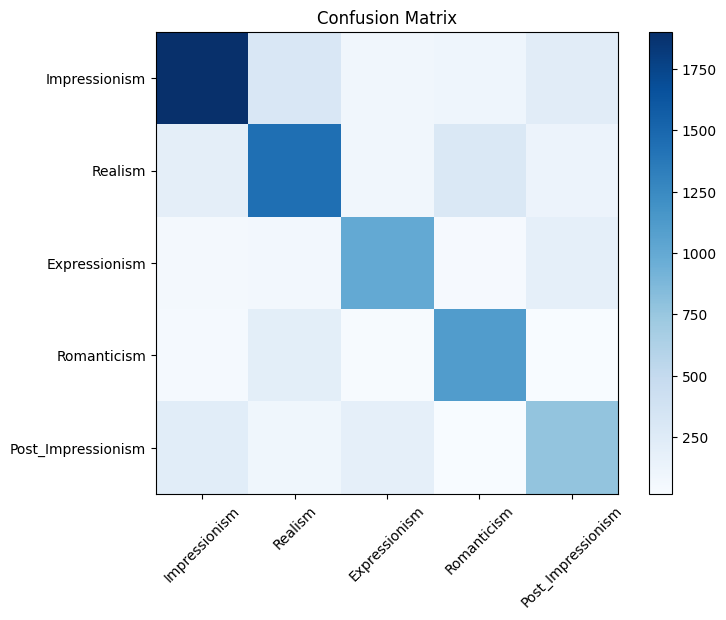

In [20]:
# 6. Evaluation on Test Set
print("\nLoading Best Model for Testing...")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

all_preds = []
all_labels = []

print("Running Inference on Test Set...")
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
acc = np.mean(np.array(all_preds) == np.array(all_labels))
prec = precision_score(all_labels, all_preds, average="macro")
rec = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, selected_classes, rotation=45)
plt.yticks(tick_marks, selected_classes)

In [21]:
# 7. Explainability (Grad-CAM Fixed for EfficientNet)
def show_gradcam(img_path, model, target_class=None):
    model.eval()
    
    # Load and preprocess image
    try:
        raw_img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    input_tensor = val_tfms(raw_img).unsqueeze(0).to(device)

    # Hooks storage
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
        
    def forward_hook(module, input, output):
        activations.append(output)

    # EfficientNet B0 features block. The last one is features[-1]
    target_layer = model.features[-1]
    
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    score = output[0, target_class]
    score.backward()

    # Generate CAM
    grads = gradients[0].cpu().data.numpy()[0] 
    fmaps = activations[0].cpu().data.numpy()[0] 
    
    # Global Average Pooling of gradients (weights)
    weights = np.mean(grads, axis=(1, 2))
    
    # Weighted sum of feature maps
    cam = np.zeros(fmaps.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmaps[i]
        
    # ReLU and normalization
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    if np.max(cam) != 0:
        cam = cam / np.max(cam)
        
    # Remove hooks
    handle_f.remove()
    handle_b.remove()
    
    # Visualization
    img_cv = np.array(raw_img.resize((224, 224)))
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)
    
    # Display
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {selected_classes[target_class]}")
    plt.axis('off')
    plt.show()

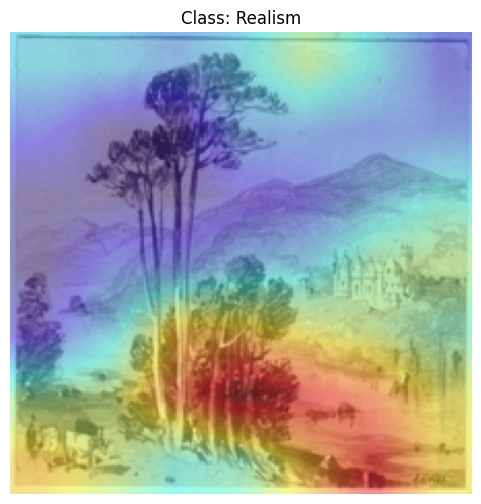

In [22]:
img_path = "/kaggle/input/wikiart/Realism/adolf-hitler_the-castle-on-the-donau.jpg"

show_gradcam(img_path, model)

In [23]:
def predict_image(img_path, model):
    img = Image.open(img_path).convert("RGB")
    img_tensor = val_tfms(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        
    top3_prob, top3_idx = torch.topk(probs, 3)
    
    print("\nModel Predictions:")
    for i in range(3):
        class_name = selected_classes[top3_idx[0][i].item()]
        probability = top3_prob[0][i].item() * 100
        print(f"{i+1}. {class_name}: {probability:.2f}%")

predict_image(img_path, model)


Model Predictions:
1. Realism: 83.96%
2. Romanticism: 8.31%
3. Impressionism: 3.37%
